In [1]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import math
import _pickle as pickle

sys.path.insert(0,'..')
import pyathena as pa

In [2]:
import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll

In [3]:
models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')

#ds = s.load_vtk(s.nums[0])

LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
/home/comejuliet/miniconda3/envs/pyathena/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WA

In [4]:
sa.models

['classic', 'ncr', 'no_spiral']

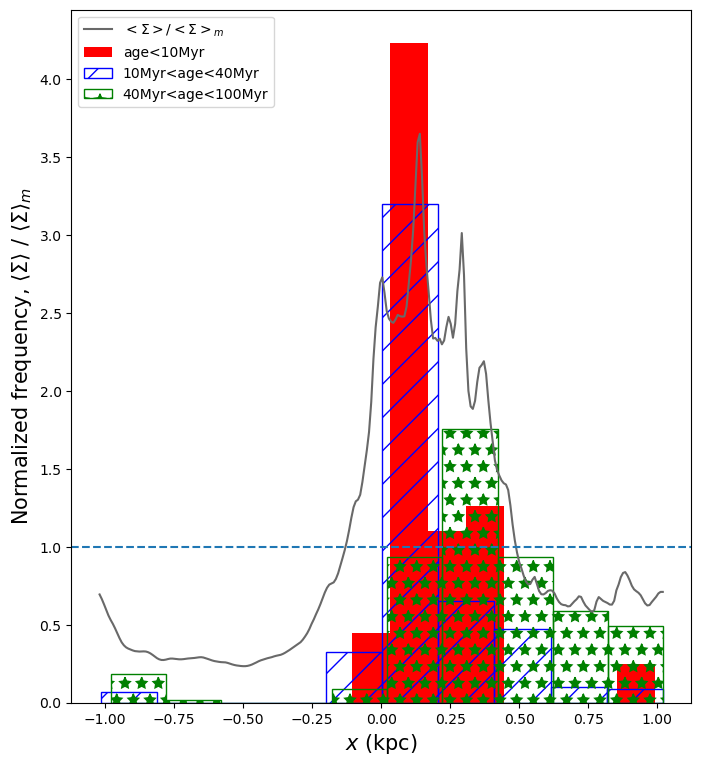

In [6]:
# STAR PARTICLE HISTOGRAM FOR SINGLE SNAPSHOT 

s = ncr

num = 250
ds = s.load_vtk(num=num)
fields_hist = ds.get_field(['density','nH'])
    

def mass_norm(mass):
    return np.sqrt(mass/10)
    
sp = s.load_starpar_vtk(num=num)
sp['mage'] *= s.u.Myr
sp['mass'] *= s.u.Msun
sp['x1'] *= s.u.kpc
sp['x2'] *= s.u.kpc
sp['x3'] *= s.u.kpc

#calculating the normalized surface density from the vtk file
sigma = np.trapz(fields_hist['nH'],axis=0)
sigma_yavg = (np.trapz(sigma,axis=0))/256
sigma_mean = (np.trapz(sigma_yavg,axis=0))/256

fig = plt.figure(figsize=(8,9))

fig = plt.plot(fields_hist['x']/1000,sigma_yavg/sigma_mean,label= '$<\Sigma>/<\Sigma>_{m}$',color = 'dimgray')

#finding the mass weighted positions of star particles in the x-direction from the starpar file
youngage = 10
adultage = 40
oldage = 100
sp10 = sp[sp.mage<youngage]
sp40 = sp[np.logical_and(sp.mage>youngage, sp.mage<adultage)]
sp100 = sp[np.logical_and(sp.mage>adultage, sp.mage<oldage)]

fig = plt.hist(sp10.x1, density=True, weights=sp10.mass,color="red", label='age<10Myr')
fig = plt.hist(sp40.x1, density=True, weights=sp40.mass,fill=False,hatch='/', ec="blue", label= '10Myr<age<40Myr')
fig = plt.hist(sp100.x1, density=True, weights=sp100.mass,fill=False,hatch='*', ec="green", label= '40Myr<age<100Myr')

fig = plt.axhline(1.,linestyle= '--')

plt.legend(loc=2)
plt.xlabel(r'$x$ (kpc)',fontsize = 15)
plt.ylabel(r'Normalized frequency, $\langle\Sigma\rangle$ / $\langle\Sigma\rangle$$_{m}$',fontsize = 15)
plt.show()


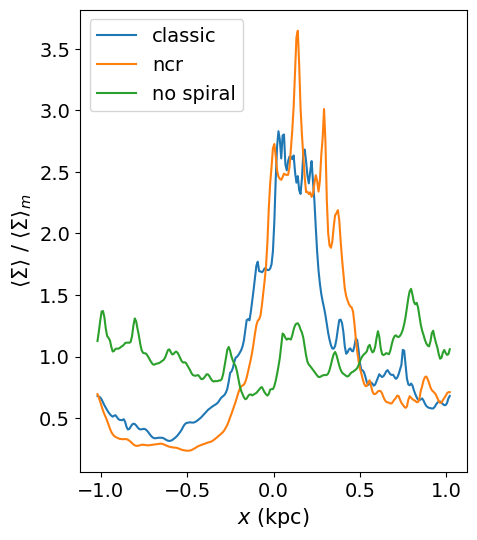

In [7]:
# comparison between the sp distributions in different models
# overplot of median to compare 

mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(5,6))

legend = ['classic', 'ncr', 'no spiral']
strmodellist = ['spiral_classic', 'spiral_ncr', 'ncr' ]

for i, mdl in enumerate(sa.models): 
    
    s = sa.set_model(mdl)
    strmodel = strmodellist[i]
    strtimet = '250' #s.nums[5]
    surf_file='surf/R8_8pc_NCRSP_'+strmodel+'.0'+strtimet+'.surf.p'
    surf=pickle.load(open(surf_file,'rb'))
    sigma = surf['data']
    #ds = s.load_vtk(num = t)
    #fields_hist = ds.get_field(['density','nH'])
    
    #sigma = np.trapz(fields_hist['nH'],axis=0)
    sigma_yavg = (np.trapz(sigma,axis=0))/256
    sigma_mean = (np.trapz(sigma_yavg,axis=0))/256
    
    fig = plt.plot(fields_hist['x']/1000,sigma_yavg/sigma_mean)
    
    plt.xlabel(r'$x$ (kpc)',fontsize = 15)
    plt.ylabel(r'$\langle\Sigma\rangle$ / $\langle\Sigma\rangle$$_{m}$',fontsize = 15)
    plt.legend(legend)

In [16]:
# temporal averaged star particle position histogram for each model

# STAR PARTICLE HISTOGRAM

s = no_spiral

strtimelist = ['210','220','230','240','250','260','270','280','290','300','310','320','330','340','350','360','370','380','390',
              '400','410','420','430','440','450','460']
npt = len(strtimelist)
sigma = [0.0]*(npt)

sigma_yavg = [0.0]*(npt)
sigma_mean = [0.0]*(npt)
sp10 = [0.0]*(npt)
sp40 = [0.0]*(npt)
sp100 = [0.0]*(npt)

spx_hist = []
spx40_hist = []
spx100_hist = []
x_hist = []
x40_hist = []
x100_hist = []

pos10 = [0.0]*npt
mass10 = [0.0]*npt
x10 = []
m10 = []

pos40 = [0.0]*npt
mass40 = [0.0]*npt
x40 = []
m40 = []

pos100 = [0.0]*npt
mass100 = [0.0]*npt
x100 = []
m100 = []
for i in range(npt):
    strtime = strtimelist[i]
    #surf_file='surf/R8_8pc_NCRSP_spiral_ncr.0'+strtime+'.surf.p'
    #surf_file='surf/R8_8pc_NCRSP_spiral_classic.0'+strtime+'.surf.p'
    surf_file='surf/R8_8pc_NCRSP_ncr.0'+strtime+'.surf.p'
    surf=pickle.load(open(surf_file,'rb'))
    sigma[i] = surf['data']
    
    def mass_norm(mass):
        return np.sqrt(mass/10)
    
    sp = s.load_starpar_vtk(num=s.nums[i])
    sp['mage'] *= s.u.Myr
    sp['mass'] *= s.u.Msun
    sp['x1'] *= s.u.kpc
    
    #calculating the normalized surface density from the vtk file
    sigma_yavg[i]=np.trapz(sigma[i],axis=0)/256
    sigma_mean[i]= np.trapz(sigma_yavg[i],axis=0)/256

    #finding the mass weighted positions of star particles in the x-direction from the starpar file
    # read the starpar file
    youngage = 10
    adultage = 40
    oldage = 100
    sp10[i] = sp[sp.mage<youngage]
    sp40[i] = sp[np.logical_and(sp.mage>youngage, sp.mage<adultage)]
    sp100[i] = sp[np.logical_and(sp.mage>adultage, sp.mage<oldage)]
    
    # here you should concatenate in time the x1 data
    pos10[i] = sp10[i].x1
    mass10[i] = sp10[i].mass
    x10.append(pos10[i])
    m10.append(mass10[i])
    
    pos40[i] = sp40[i].x1
    mass40[i] = sp40[i].mass
    x40.append(pos40[i])
    m40.append(mass40[i])
    
    pos100[i] = sp100[i].x1
    mass100[i] = sp100[i].mass
    x100.append(pos100[i])
    m100.append(mass100[i])
    
def flatten(l):
    return [item for sublist in l for item in sublist]

x10_flat = flatten(x10)
m10_flat = flatten(m10)

x40_flat = flatten(x40)
m40_flat = flatten(m40)

x100_flat = flatten(x100)
m100_flat = flatten(m100)

In [17]:
s = no_spiral
ds = s.load_vtk(num=s.nums[0])
coord_hist = ds.get_field(['density'])

sigma_yavg_t = [0.0]*256
for j in range(256):
    for i in range(26):
        sigma_yavg_t[j] = np.average(sigma_yavg[i][j]) 
sigma_mean_t = np.average(sigma_mean)

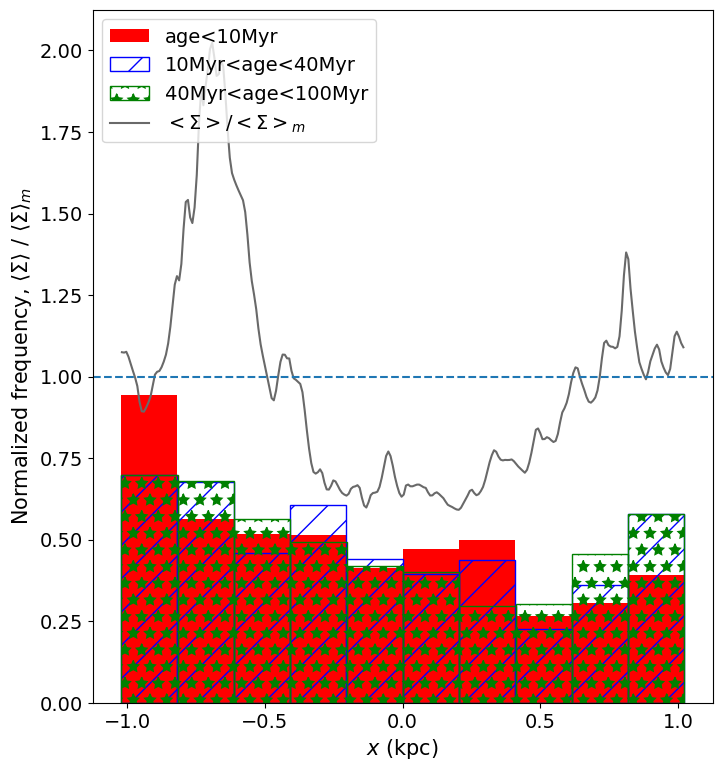

In [18]:
fig = plt.figure(figsize=(8,9))
fig = plt.hist(x10_flat, density=True, weights=m10_flat,color="red", label='age<10Myr')
fig = plt.hist(x40_flat, density=True, weights=m40_flat,fill=False,hatch='/', ec="blue", label= '10Myr<age<40Myr')
fig = plt.hist(x100_flat, density=True, weights=m100_flat,fill=False,hatch='*', ec="green", label= '40Myr<age<100Myr')

fig = plt.plot(coord_hist['x']/1000, sigma_yavg_t/sigma_mean_t,label= '$<\Sigma>/<\Sigma>_{m}$',color = 'dimgray')
fig = plt.axhline(1.,linestyle= '--')

plt.legend(loc=2)
plt.xlabel(r'$x$ (kpc)',fontsize = 15)
plt.ylabel(r'Normalized frequency, $\langle\Sigma\rangle$ / $\langle\Sigma\rangle$$_{m}$',fontsize = 15)
plt.show()


In [11]:
# when ncr
sigmagas_ncr = sigma_yavg_t/sigma_mean_t

In [15]:
# when classic
sigmagas_classic = sigma_yavg_t/sigma_mean_t

In [20]:
# when no spiral
sigmagas_nospiral  = sigma_yavg_t/sigma_mean_t

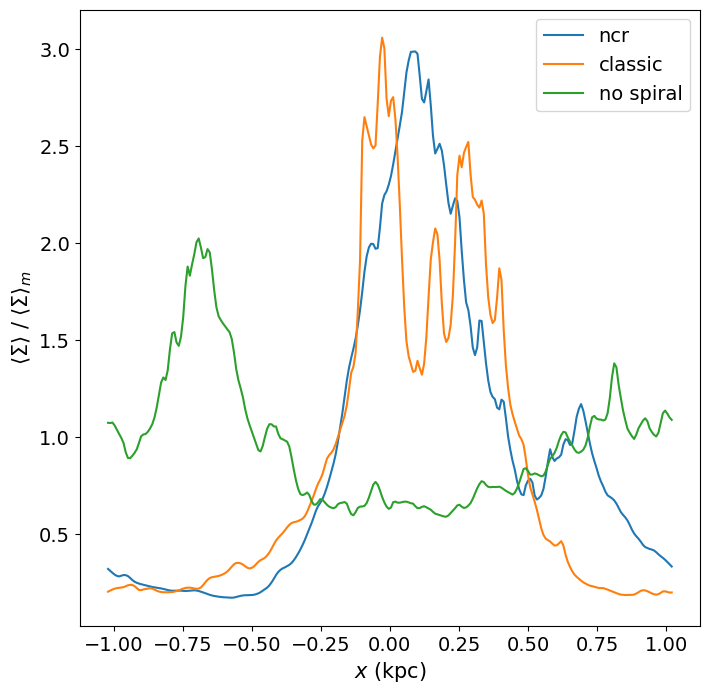

In [28]:
plt.figure(figsize=(8,8))
plt.plot(coord_hist['x']/1000,sigmagas_ncr,label='ncr')
plt.plot(coord_hist['x']/1000,sigmagas_classic,label='classic')
plt.plot(coord_hist['x']/1000,sigmagas_nospiral,label='no spiral')
plt.legend()
plt.xlabel(r'$x$ (kpc)',fontsize = 15)
plt.ylabel(r'$\langle\Sigma\rangle$ / $\langle\Sigma\rangle$$_{m}$',fontsize = 15)
plt.show()
